In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors.kde import KernelDensity
import matplotlib.pyplot as plt

/Users/aennassiri/anaconda3/envs/Research/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def mp_pdf(var, q, points):
    """
    Marcenko-Pastur
    :param var: The variance
    :type var: float
    :param q: N/T number of observations on the number of dates
    :type q: float
    :param points:
    :type points: int
    :return:The Marcenko-Pastur probability density function
    :rtype: pd.Series
    """

    eigen_min = var * (1-(1./q)**.5)**2
    eigen_max = var * (1+(1./q)**.5)**2
    eigen_values = np.linspace(eigen_min, eigen_max, points)
    pdf = q/(2*np.pi*var*eigen_values)*((eigen_max-eigen_values)*(eigen_values-eigen_min))**.5
    pdf = pd.Series(pdf, index=eigen_values)
    return pdf

def get_pca(matrix):
    """
    Function to retreive the eigenvalues and eigenvector from a Hermitian matrix
    :param matrix: Hermitian matrix
    :type matrix:
    :return:
    :rtype:
    """
    eigenvalues, eigenvectors = np.linalg.eigh(matrix)
    indices = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[indices], eigenvectors[:, indices]
    eigenvalues = np.diagflat(eigenvalues)
    return eigenvalues, eigenvectors

def fit_kde(obs, bandwidth=0.25, kernel='gaussian', x=None):
    """
    Fit kernel to a series of observations and derive the probablity of obs
    :param obs:
    :type obs:
    :param bandwidth:
    :type bandwidth:
    :param kernel:
    :type kernel:
    :param x:
    :type x:
    :return:
    :rtype:
    """
    if len(obs.shape) == 1:
        obs=obs.reshape(-1,1)
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(obs)
    if x is None:
        x = np.unique(obs).reshape(-1, 1)
    log_prob = kde.score_samples(x)
    pdf = pd.Series(np.exp(log_prob), index=x.flatten())
    return pdf

In [3]:
x = np.random.normal(size=(10000, 1000))
eval0, evec0 = get_pca(np.corrcoef(x, rowvar=False))
pdf0 = mp_pdf(1., q=x.shape[0]/float(x.shape[1]), points=1000)
pdf1 = fit_kde(np.diag(eval0), bandwidth=0.01)


## Testing a random matrix

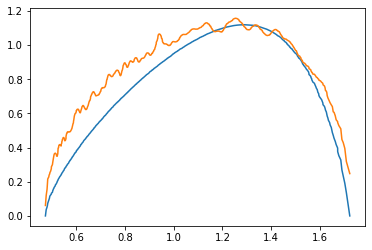

In [4]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(eval0.diagonal(), pdf0)
ax.plot(eval0.diagonal(), pdf1)


## Testing with a random matrix with a signal

In [5]:
def get_random_covariance(columns_number, facts_number):
    """
    Get a random covariance and add signal to it
    :param columns_number:
    :type columns_number:
    :param facts_number:
    :type facts_number:
    :return:
    :rtype:
    """
    w = np.random.normal(size=(columns_number, facts_number))
    covariance = np.dot(w, w.T)
    covariance += np.diag(np.random.uniform(size=columns_number))
    return covariance

def cov_to_corr(covariance):
    std = np.sqrt(np.diag(covariance))
    correlation = covariance/np.outer(std, std)
    correlation[correlation<-1], correlation[correlation>1] = -1, 1
    return correlation

In [6]:
alpha = 0.995
columns_number = 1000
facts_number = 100
q = 10

covariance = np.cov(np.random.normal(size=(columns_number*q, columns_number)), rowvar=False)
covariance = alpha*covariance + (1-alpha)*get_random_covariance(columns_number, facts_number)

corr0 = cov_to_corr(covariance)
eval0, evec0 = get_pca(corr0)

from scipy.optimize import minimize

def err_pdfs(var, eigenvalues, q, bandwidth, points=1000):
    pdf0 = mp_pdf(var, q, points)
    pdf1 = fit_kde(eigenvalues, bandwidth, x=pdf0.index.values)
    sse = np.sum((pdf1 - pdf0)**2)
    return sse

def find_max_eval(eigenvalues, q, bandwidth):
    out = minimize(lambda *x: err_pdfs(*x), 0.5, args=(eigenvalues, q, bandwidth),
                   bounds=((1E-5, 1-1E-5),))

    if out['success']:
        var = out['x'][0]
    else:
        var = 1
    eigen_max = var*(1+(1./q)**0.5)**2
    return eigen_max, var

emax0, var0 = find_max_eval(np.diag(eval0), q, bandwidth=0.01)
facts_number0 = eval0.shape[0] - np.diag(eval0)[::-1].searchsorted(emax0)

ValueError: Index data must be 1-dimensional

In [ ]:
def denoised_corr(eigenvalues,eigenvector,facts_number):
# Remove noise from corr by fixing random eigenvalues
    eigenvalues_=np.diag(eigenvalues).copy()
    eigenvalues_[facts_number:]=eigenvalues_[facts_number:].sum()/float(eigenvalues_.shape[0]-facts_number)
    eigenvalues_=np.diag(eigenvalues_)
    corr=np.dot(eigenvalues,eigenvalues_).dot(eigenvector.T)
    corrç=cov_to_corr(corr)
    return corr1
#--------------------------------------------------- corr1=denoisedCorr(eVal0,eVec0,nFacts0) eVal1,eVec1=getPCA(corr1)

